C:\Users\prash\AppData\Local\Temp\ipykernel_28304\668195780.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))


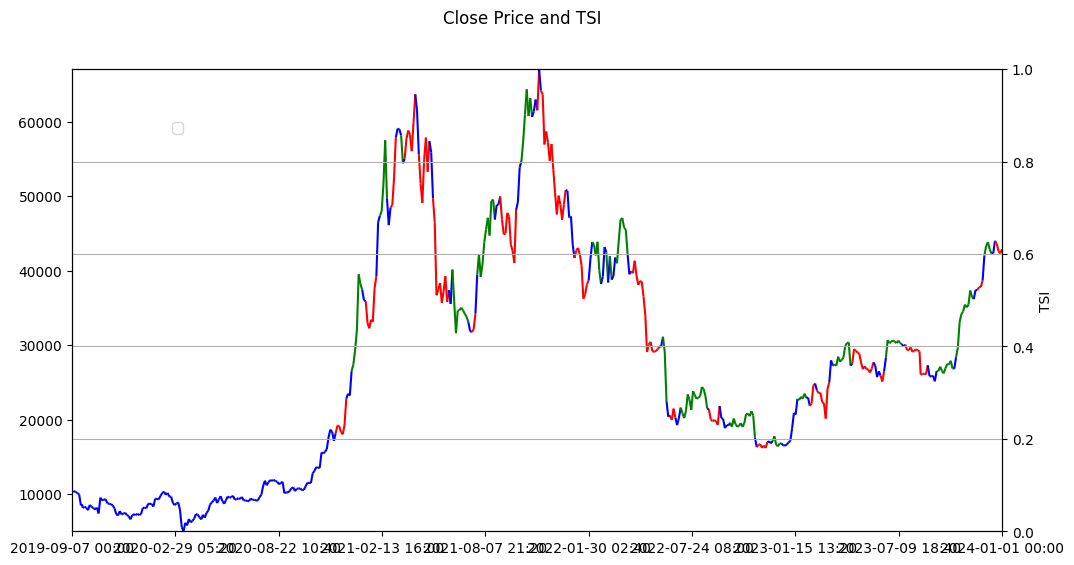

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

df = pd.read_csv('data\BTC\BTC_2019_2023_3d.csv')

atr_num = 14
atr_window = 14
df["H-L"] = df["high"] - df["low"]
df["H-PC"] = abs(df["high"] - df["close"].shift(1))
df["L-PC"] = abs(df["low"] - df["close"].shift(1))
df["TR"] = df[["H-L","H-PC","L-PC"]].max(axis=1, skipna=False)
df["ATR"] = df["TR"].ewm(com=atr_num, min_periods=atr_num).mean()

df["Constant_Val"]= np.where(df['ATR']>1200, 1, -1)

# Parameters for TSI
long_period = 10
short_period = 4

# TSI Calculation
price_diff = df['close'].diff()
abs_price_diff = price_diff.abs()

# Smoothed Momentum
smoothed_diff = price_diff.ewm(span=long_period, adjust=False).mean()
double_smoothed_diff = smoothed_diff.ewm(span=short_period, adjust=False).mean()

# Smoothed Absolute Momentum
smoothed_abs_diff = abs_price_diff.ewm(span=long_period, adjust=False).mean()
double_smoothed_abs_diff = smoothed_abs_diff.ewm(span=short_period, adjust=False).mean()

# Calculate TSI
df['TSI'] = (double_smoothed_diff / double_smoothed_abs_diff) * 100
df['Signal'] = df['TSI'].ewm(span=7, adjust=False).mean()


df['TSI_signal'] = np.where((df['TSI']>df['Signal']) & ((df['Signal'] > df['Signal'].rolling(7).quantile(0.70))),1, np.where((df['TSI']<df['Signal']) & ((df['Signal'] < df['Signal'].rolling(7).quantile(0.30))),-1, 0))
# df = df[140:]
df['datetime'] = pd.to_datetime(df['datetime'])

# Convert datetime to numerical format (matplotlib requires numerical x-values)
df['datetime_num'] = df['datetime'].map(pd.Timestamp.timestamp)

# Prepare line segments
segments = [
    [(df.iloc[i]['datetime_num'], df.iloc[i]['close']), 
     (df.iloc[i + 1]['datetime_num'], df.iloc[i + 1]['close'])]
    for i in range(len(df) - 1)
]

# Assign colors based on 'Percentile_Val'
colors = np.where((df['TSI_signal'][:-1] == 1) & (df['Constant_Val'][:-1] == 1), 'green', 
         np.where((df['TSI_signal'][:-1] == -1) & (df['Constant_Val'][:-1] == 1), 'red', 'blue'))

# Create LineCollection
lc = LineCollection(segments, colors=colors, linewidths=1.5)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.add_collection(lc)

# Set axis limits
ax.set_xlim(df['datetime_num'].min(), df['datetime_num'].max())
ax.set_ylim(df['close'].min(), df['close'].max())

# Format x-axis back to readable datetime
ax.set_xticks(np.linspace(df['datetime_num'].min(), df['datetime_num'].max(), 10))
ax.set_xticklabels(pd.to_datetime(ax.get_xticks(), unit='s').strftime('%Y-%m-%d %H:%M'))


ax2 = ax.twinx()
ax2.set_ylabel('TSI', color='black')

# Plot the ADX line on the second y-axis
# ax2.plot(df['datetime_num'], df['TSI'], label='TSI', color='black')
# ax2.plot(df['datetime_num'], df['Signal'], label='Signal', color='orange')

# Ensure tick labels on the second y-axis are visible
ax2.tick_params(axis='y', labelcolor='black')

# Add a title and legend
fig.suptitle('Close Price and TSI')
ax2.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Add grid for better visualization
plt.grid()

# Show the plot
plt.show()



C:\Users\prash\AppData\Local\Temp\ipykernel_28304\1787050279.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))


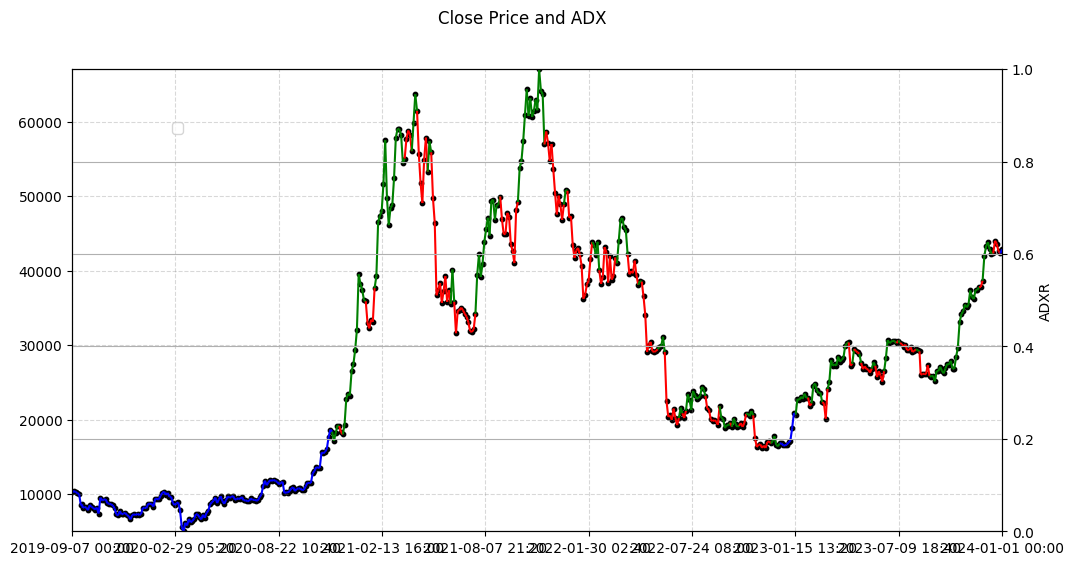

In [3]:
## ADX Optimisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
# Load your CSV data
df = pd.read_csv('data/BTC/BTC_2019_2023_3d.csv')

# Volatility Regimes
atr_num = 14
df["H-L"] = df["high"] - df["low"]
df["H-PC"] = abs(df["high"] - df["close"].shift(1))
df["L-PC"] = abs(df["low"] - df["close"].shift(1))
df["TR"] = df[["H-L","H-PC","L-PC"]].max(axis=1, skipna=False)
df["ATR"] = df["TR"].ewm(com=atr_num, min_periods=atr_num).mean()
df["Constant_Val"]= np.where(df['ATR'] > 1200, 1, -1)



        
adx_num = 6
adxr_period = 4
df["upmove"] = df["high"] - df["high"].shift(1)
df["downmove"] = df["low"].shift(1) - df["low"]
df["+dm"] = np.where((df["upmove"] > df["downmove"]) & (df["upmove"] > 0), df["upmove"], 0)
df["-dm"] = np.where((df["downmove"] > df["upmove"]) & (df["downmove"] > 0), df["downmove"], 0)

df["+di"] = 100 * (df["+dm"].rolling(window=adx_num).sum() / df["ATR"])
df["-di"] = 100 * (df["-dm"].rolling(window=adx_num).sum() / df["ATR"])

df["DX"] = 100 * (abs(df["+di"] - df["-di"]) / (df["+di"] + df["-di"]))
df["ADX"] = df["DX"].ewm(alpha=1/adx_num, min_periods=adx_num).mean()
df['ADXR'] = (df['ADX'] + df['ADX'].shift(adxr_period)) / 2
    
df['ADXR_signal'] = np.where((df['ADXR'] >= 25) & (df['+di']>df['-di']) , 1, np.where((df['ADXR'] >= 25) & (df['+di']<df['-di']) , -1, 0))



# df = df[125:]
df['datetime'] = pd.to_datetime(df['datetime'])

# Convert datetime to numerical format (matplotlib requires numerical x-values)
df['datetime_num'] = df['datetime'].map(pd.Timestamp.timestamp)

# Prepare line segments

segments = [
    [(df.iloc[i]['datetime_num'], df.iloc[i]['close']), 
    (df.iloc[i + 1]['datetime_num'], df.iloc[i + 1]['close'])]
    for i in range(len(df) - 1)
]
segments.insert(0, ((df.iloc[0]['datetime_num'], df.iloc[0]['close']), 
    (df.iloc[1]['datetime_num'], df.iloc[1]['close'])))

# Assign colors based on 'Percentile_Val'
colors = np.where((df['ADXR_signal'][:-1] == 1) & (df['Constant_Val'][:-1] == 1), 'green', 
        np.where((df['ADXR_signal'][:-1] == -1) & (df['Constant_Val'][:-1] == 1), 'red', 'blue'))

# Create LineCollection
lc = LineCollection(segments, colors=colors, linewidths=1.5)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.add_collection(lc)

# Set axis limits
ax.set_xlim(df['datetime_num'].min(), df['datetime_num'].max())
ax.set_ylim(df['close'].min(), df['close'].max())

# Format x-axis back to readable datetime
ax.set_xticks(np.linspace(df['datetime_num'].min(), df['datetime_num'].max(), 10))
ax.set_xticklabels(pd.to_datetime(ax.get_xticks(), unit='s').strftime('%Y-%m-%d %H:%M'))
ax.scatter(df['datetime_num'], df['close'], color='black', s=10, label='Close Points')

ax.grid(which='major', axis='x', linestyle='--', alpha=0.3, color='gray')  # Faded vertical grid
ax.grid(which='major', axis='y', linestyle='--', alpha=0.3, color='gray')  # Faded horizontal grid

ax2 = ax.twinx()
ax2.set_ylabel('ADXR', color='black')

# Plot the ADX line on the second y-axis
# ax2.plot(df['datetime_num'], df['ADXR'], label='ADXR', color='black')
# ax2.plot(df['datetime_num'], df['ADX'], label='ADX', color='black')

# Ensure tick labels on the second y-axis are visible
ax2.tick_params(axis='y', labelcolor='black')

# Add a title and legend
fig.suptitle('Close Price and ADX')
ax2.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Add grid for better visualization
plt.grid()

# Show the plot
plt.show()






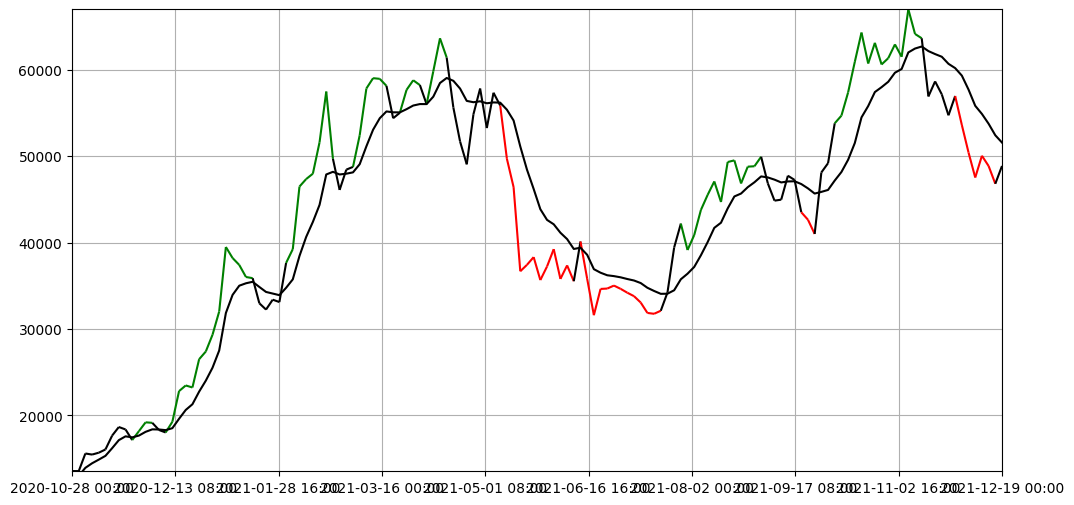

In [12]:
##KAMA Optimisation


df = pd.read_csv('data/BTC/BTC_2019_2023_3d.csv')

# Volatility Regimes
atr_num = 14
atr_window = 14
df["H-L"] = df["high"] - df["low"]
df["H-PC"] = abs(df["high"] - df["close"].shift(1))
df["L-PC"] = abs(df["low"] - df["close"].shift(1))
df["TR"] = df[["H-L","H-PC","L-PC"]].max(axis=1, skipna=False)
df["ATR"] = df["TR"].ewm(com=atr_num, min_periods=atr_num).mean()
df["Constant_Val"]= np.where(df['ATR'] > 1200, 1, -1)

n = 14
fast = 4
slow = 30

# Calculate the Efficiency Ratio (ER)
price_change = df['close'].diff(n).abs()
volatility = df['close'].diff().abs().rolling(window=n).sum()
efficiency_ratio = price_change / volatility.replace(0, np.nan)

# Calculate the Smoothing Constant (SC)
fast_sc = 2 / (fast + 1)
slow_sc = 2 / (slow + 1)
sc = efficiency_ratio * fast_sc + (1 - efficiency_ratio) * slow_sc

# Initialize KAMA array
kama = df['close'].rolling(window=n).mean()  # Start with SMA for the first `n` values

# Calculate KAMA iteratively
for i in range(n, len(df)):
    kama.iloc[i] = kama.iloc[i - 1] + sc.iloc[i] * (df['close'].iloc[i] - kama.iloc[i - 1])

# Add the KAMA values to the DataFrame
df['KAMA'] = kama


# df['signals'] = np.where(df['close'] > df['KAMA'], 1, -1)
df['signals'] = np.where((df['KAMA'] > df['KAMA'].rolling(10).quantile(0.90)) & (df['close'] > df['KAMA']), 1, np.where((df['KAMA'] < df['KAMA'].rolling(10).quantile(0.10)) & (df['close'] < df['KAMA']), -1,0))


df = df[140:280]
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime_num'] = df['datetime'].map(pd.Timestamp.timestamp)

# Prepare line segments
segments = [
    [(df.iloc[i]['datetime_num'], df.iloc[i]['close']), 
     (df.iloc[i + 1]['datetime_num'], df.iloc[i + 1]['close'])]
    for i in range(len(df) - 1)
]
segments.insert(0, ((df.iloc[0]['datetime_num'], df.iloc[0]['close']), 
    (df.iloc[1]['datetime_num'], df.iloc[1]['close'])))

# Assign colors based on 'Percentile_Val'
colors = np.where((df['signals'][:-1] == 1) & (df['Constant_Val'][:-1] == 1), 'green', 
         np.where((df['signals'][:-1] == -1) & (df['Constant_Val'][:-1] == 1), 'red', 'black'))

# Create LineCollection
lc = LineCollection(segments, colors=colors, linewidths=1.5)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.add_collection(lc)

# Set axis limits
ax.set_xlim(df['datetime_num'].min(), df['datetime_num'].max())
ax.set_ylim(df['close'].min(), df['close'].max())
ax.set_xticks(np.linspace(df['datetime_num'].min(), df['datetime_num'].max(), 10))
ax.set_xticklabels(pd.to_datetime(ax.get_xticks(), unit='s').strftime('%Y-%m-%d %H:%M'))
ax.plot(df['datetime_num'], df['KAMA'], label='KAMA', color='black')
# ax.scatter(df['datetime_num'], df['close'], color='black', s=10, label='Close Points')

# ax2 = ax.twinx()
# ax2.set_ylabel('KAMA', color='black')

# ax2.tick_params(axis='y', labelcolor='black')
# fig.suptitle('Close Price and KAMA')
# ax2.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Add grid for better visualization
plt.grid()

# Show the plot
plt.show()

df.to_csv('ab.csv', index=False)


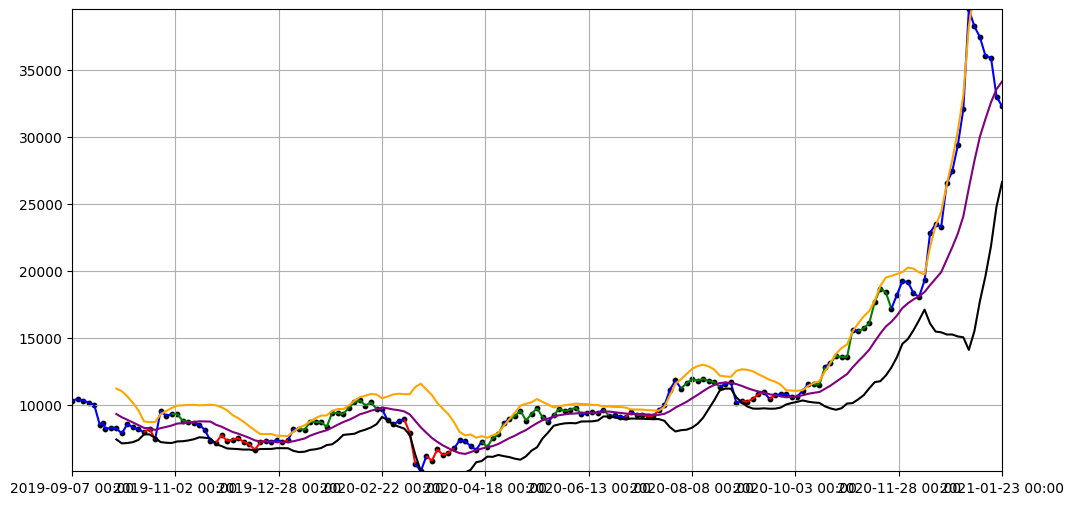

In [18]:
##BB Optimisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

df = pd.read_csv('data\BTC\BTC_2019_2023_3d.csv')

# Volatility Regimes
atr_num = 14
df["H-L"] = df["high"] - df["low"]
df["H-PC"] = abs(df["high"] - df["close"].shift(1))
df["L-PC"] = abs(df["low"] - df["close"].shift(1))
df["TR"] = df[["H-L","H-PC","L-PC"]].max(axis=1, skipna=False)
df["ATR"] = df["TR"].ewm(com=atr_num, min_periods=atr_num).mean()
df["Constant_Val"]= np.where(df['ATR'] > 1200, 1, -1)

bb_num=10    
df["MB"] = df["close"].rolling(bb_num).mean() 
df["UB"] = df["MB"] + 2 * df["close"].rolling(bb_num).std(ddof=0)
df["LB"] = df["MB"] - 2 * df["close"].rolling(bb_num).std(ddof=0)

df["BB_signal"] = 0  

df.loc[(df["close"] > df["LB"]), "BB_signal"] = 1   # Buy signal: when price crosses above the lower band    
df.loc[(df["close"] < df["UB"]), "BB_signal"] = -1 # Sell signal: when price crosses below the upper band
    
df['BB_signal'] = np.where((df["close"] > df["MB"]) & (df["close"] <= df["UB"]) & (df['MB'] > df['MB'].rolling(6).quantile(0.80)), 1, 
                           np.where((df["close"] < df["MB"]) & (df["close"] >= df["LB"]) & (df['MB'] < df['MB'].rolling(6).quantile(0.20)), -1, 0))

df = df[:170]
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime_num'] = df['datetime'].map(pd.Timestamp.timestamp)

# Prepare line segments
segments = [
    [(df.iloc[i]['datetime_num'], df.iloc[i]['close']), 
     (df.iloc[i + 1]['datetime_num'], df.iloc[i + 1]['close'])]
    for i in range(len(df) - 1)
]

# Assign colors based on 'Percentile_Val'
colors = np.where((df['BB_signal'][:-1] == 1) & (df['Constant_Val'][:-1] == -1), 'green', 
         np.where((df['BB_signal'][:-1] == -1) & (df['Constant_Val'][:-1] == -1), 'red', 'blue'))

# Create LineCollection
lc = LineCollection(segments, colors=colors, linewidths=1.5)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.add_collection(lc)

# Set axis limits
ax.set_xlim(df['datetime_num'].min(), df['datetime_num'].max())
ax.set_ylim(df['close'].min(), df['close'].max())
ax.set_xticks(np.linspace(df['datetime_num'].min(), df['datetime_num'].max(), 10))
ax.set_xticklabels(pd.to_datetime(ax.get_xticks(), unit='s').strftime('%Y-%m-%d %H:%M'))
ax.plot(df['datetime_num'], df['LB'], label='LB', color='black')
ax.plot(df['datetime_num'], df['UB'], label='UB', color='orange')
ax.plot(df['datetime_num'], df['MB'], label='MB', color='purple')

ax.scatter(df['datetime_num'], df['close'], color='black', s=10, label='Close Points')

# ax2 = ax.twinx()
# ax2.set_ylabel('KAMA', color='black')

# ax2.tick_params(axis='y', labelcolor='black')
# fig.suptitle('Close Price and KAMA')
# ax2.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Add grid for better visualization
plt.grid()

# Show the plot
plt.show()

df.to_csv('ab.csv', index=False)


In [ ]:
##KAMA Optimisation


df = pd.read_csv('BTC_2019_2024_3d.csv')

# Volatility Regimes
atr_num = 14
atr_window = 14
df["H-L"] = df["high"] - df["low"]
df["H-PC"] = abs(df["high"] - df["close"].shift(1))
df["L-PC"] = abs(df["low"] - df["close"].shift(1))
df["TR"] = df[["H-L","H-PC","L-PC"]].max(axis=1, skipna=False)
df["ATR"] = df["TR"].ewm(com=atr_num, min_periods=atr_num).mean()
df["Constant_Val"]= np.where(df['ATR'] > 1200, 1, -1)

n = 14
fast = 4
slow = 30

# Calculate the Efficiency Ratio (ER)
price_change = df['close'].diff(n).abs()
volatility = df['close'].diff().abs().rolling(window=n).sum()
efficiency_ratio = price_change / volatility.replace(0, np.nan)

# Calculate the Smoothing Constant (SC)
fast_sc = 2 / (fast + 1)
slow_sc = 2 / (slow + 1)
sc = efficiency_ratio * fast_sc + (1 - efficiency_ratio) * slow_sc

# Initialize KAMA array
kama = df['close'].rolling(window=n).mean()  # Start with SMA for the first `n` values

# Calculate KAMA iteratively
for i in range(n, len(df)):
    kama.iloc[i] = kama.iloc[i - 1] + sc.iloc[i] * (df['close'].iloc[i] - kama.iloc[i - 1])

# Add the KAMA values to the DataFrame
df['KAMA'] = kama


# df['signals'] = np.where(df['close'] > df['KAMA'], 1, -1)
df['signals'] = np.where((df['KAMA'] > df['KAMA'].rolling(7).quantile(0.95)) & (df['close'] > df['KAMA']), 1, np.where((df['KAMA'] < df['KAMA'].rolling(7).quantile(0.05)) & (df['close'] < df['KAMA']), -1,0))


# df = df[140:]
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime_num'] = df['datetime'].map(pd.Timestamp.timestamp)

# Prepare line segments
segments = [
    [(df.iloc[i]['datetime_num'], df.iloc[i]['close']), 
     (df.iloc[i + 1]['datetime_num'], df.iloc[i + 1]['close'])]
    for i in range(len(df) - 1)
]

# Assign colors based on 'Percentile_Val'
colors = np.where((df['signals'][:-1] == 1) & (df['Constant_Val'][:-1] == 1), 'green', 
         np.where((df['signals'][:-1] == -1) & (df['Constant_Val'][:-1] == 1), 'red', 'blue'))

# Create LineCollection
lc = LineCollection(segments, colors=colors, linewidths=1.5)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.add_collection(lc)

# Set axis limits
ax.set_xlim(df['datetime_num'].min(), df['datetime_num'].max())
ax.set_ylim(df['close'].min(), df['close'].max())
ax.set_xticks(np.linspace(df['datetime_num'].min(), df['datetime_num'].max(), 10))
ax.set_xticklabels(pd.to_datetime(ax.get_xticks(), unit='s').strftime('%Y-%m-%d %H:%M'))
ax.plot(df['datetime_num'], df['KAMA'], label='KAMA', color='black')
ax.scatter(df['datetime_num'], df['close'], color='black', s=10, label='Close Points')

# ax2 = ax.twinx()
# ax2.set_ylabel('KAMA', color='black')

# ax2.tick_params(axis='y', labelcolor='black')
# fig.suptitle('Close Price and KAMA')
# ax2.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Add grid for better visualization
plt.grid()

# Show the plot
plt.show()

df.to_csv('ab.csv', index=False)
